# Calmodulin Final Analysis

This notebook contains all of the analysis, figure generation, and detailed explanations for the calmodulin dataset. 

tICA distance and MFPT was used as a "golden" standard metric to compare our methods to the MSM, our gold standard.

tICA between each structure was computed by using MSMBuilder. In this series of plots, we compare the distance in various spaces (found by ISOMAP, Spectral Embedding, PCA, and raw XYZ) vs the distance in the space found by tICA. 

MFPT was computed using MSMBuilder.

Parameters for presentation: num_frames = 5000, n_neighbors = 2000

#### Overall Notes and Impressions

Good correlations with MFPT and distance in tICA does not necessarily imply that the coordinates will represent dominant dynamical modes.

PCA is quite good, perhaps because of the linear model prior. tICA and PCA are both linear models, and if one is using the tICA as the gold standard, PCA may perform very well since it assumes that the eigenfunctions are some type of linear combination of the dihedral angles.

Spectral Embedding is certainly the best at finding large "breaks" or "jumps" in dynamical processes, perhaps even better than tICA. In a use case, if the molecule is suspected of transitioning in a subtle, but abrupt way, the behavior could best be studied with SE/PCA.

ISOMAP was on par with PCA on generating correlations between the distance in its transformed coordinate system and MFPT/tICA distance, but failed to track the dynamical processes.

One justification for performing PCA on top of SE/ISOMAP is that these nonlinear techniques may find approximate eigenfunctions of the transfer matrix, PCA serves as the last push into finding meaningful dimensions to project onto.

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
from sklearn.decomposition import PCA
import msmbuilder.utils as msmUtils
from msmbuilder.tpt import mfpts
import mdtraj as md
from scipy import ndimage, stats
from sklearn.metrics import r2_score

In [3]:
%matplotlib inline

In [115]:
num_frames = 5000
n_neighbors = 2000

In [116]:
# Import the coordinates of each frame in the tICA space, saved from the MSMBuilder.
base = 'C:\\Users\\minch_000\\Documents\\TJ_data'
tICA_coordinates = np.loadtxt(base + '\\apo_calmodulin\sim_datasets\\tICA_coord_+apo_calmodulin.csv', delimiter=',')

In [117]:
# Import raw dihedral features and corresponding indices
X_dihedral = np.loadtxt(base + r'\apo_calmodulin\sim_datasets\raw_angle_' + str(num_frames) + '.csv', delimiter=',')
indices = np.loadtxt(base + '\\apo_calmodulin\sim_datasets\\indices_' + str(num_frames) + '.csv', delimiter=',').astype(int)

#### Compute Spectral Embedding and PCA

In [118]:
pca = PCA(n_components=2)
X_pc = pca.fit_transform(X_dihedral)
se = manifold.SpectralEmbedding(n_neighbors=n_neighbors, n_components=3)
X_se = pca.fit_transform(se.fit_transform(X_dihedral))
#X_se = se.fit_transform(X_dihedral)

In [119]:
X_iso = np.loadtxt(base + r'\apo_calmodulin\sim_datasets\X_isomap_40_40_' + str(num_frames) + '.csv', delimiter=',')
X_iso = X_iso[~np.isnan(X_iso).any(axis=1)]
X_iso = X_iso[~(X_iso > 5000).any(axis=1)]
X_iso = X_iso[~(X_iso < -5000).any(axis=1)]
X_iso = pca.fit_transform(X_iso)

#### tICA distance vs dihedral/PCA/Spectral Embedding

Dihedral distance serves as the baseline. PCA on raw dihedral angles and Spectral Embedding.

In [120]:
# Function for plotting various distance vs tICA
def plot_against_tICA(tx, x, indices, num_points=100):
    xdist = []
    txdist = []
    for p in range(num_points):
        frame_pair = np.random.randint(low=0, high=x.shape[0]-1, size=2) # frame number in sim_data
        xdist.append(np.linalg.norm(x[frame_pair[0],:] - x[frame_pair[1], :]))
        txdist.append(np.linalg.norm(tx[indices[frame_pair[0]],:] - tx[indices[frame_pair[1]], :]))
    plt.scatter(xdist, txdist)
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(xdist), np.array(txdist))
    return r_value**2

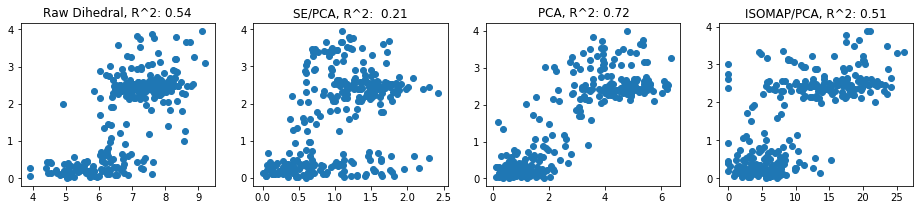

In [121]:
plt.figure(figsize=(4*4, 3))
plt.subplot(1, 4, 1)
rsq = plot_against_tICA(tICA_coordinates[:, 0:2], X_dihedral, indices, 300);
plt.title('Raw Dihedral, R^2: ' + ('%.2f' % rsq))
plt.subplot(1, 4, 2)
rsq = plot_against_tICA(tICA_coordinates[:, 0:2], X_se, indices, 300);
plt.title('SE/PCA, R^2:  ' + ('%.2f' % rsq))
plt.subplot(1, 4, 3)
rsq = plot_against_tICA(tICA_coordinates[:, 0:2], X_pc, indices, 300);
plt.title('PCA, R^2: ' + ('%.2f' % rsq))
plt.subplot(1, 4, 4)
rsq = plot_against_tICA(tICA_coordinates[:, 0:2], X_iso, indices, 300);
plt.title('ISOMAP/PCA, R^2: ' + ('%.2f' % rsq))

#### MFPT vs dihedral/PCA/Spectral Embedding

Dihedral distance serves as the baseline. PCA on raw dihedral angles and Spectral Embedding.

In [122]:
# Import MSM files
msm = msmUtils.load(base + r'\apo_calmodulin\sim_datasets\msm_apo_calmodulin.pkl')
sample_cluster_assignments = np.loadtxt(base + r'\apo_calmodulin\sim_datasets\sample_cluster_assignment_' + str(num_frames) + '.csv', delimiter=',')

In [123]:
# Function for plotting various distance vs MFPT
def plot_against_MFPT(msm, x, sample_cluster_assignments, num_points=100):
    xdist = []
    mfpt = []
    mfpt_matrix = mfpts(msm) + mfpts(msm).transpose()
    for p in range(num_points):
        frame_pair = np.random.randint(low=0, high=x.shape[0]-1, size=2) # frame number in sim_data
        msm_frame_pair = (msm.mapping_[sample_cluster_assignments[frame_pair[0]]], msm.mapping_[sample_cluster_assignments[frame_pair[1]]])
        d = np.linalg.norm(x[frame_pair[0],:] - x[frame_pair[1], :], 2)
        m = mfpt_matrix[msm_frame_pair[0]][msm_frame_pair[1]]
        if msm_frame_pair[0] != msm_frame_pair[1] and m < 2000:
            xdist.append(d)
            mfpt.append(np.sqrt(m))
    plt.scatter(xdist, mfpt)
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(xdist), np.array(mfpt))
    return r_value**2

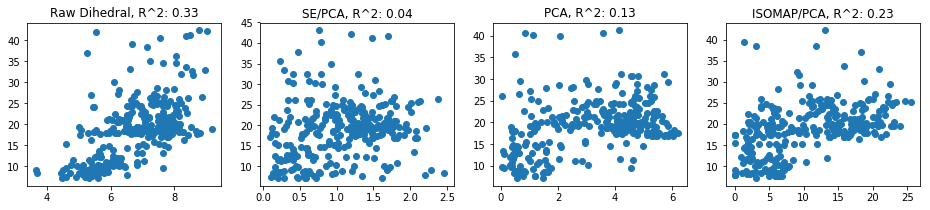

In [124]:
plt.figure(figsize=(4*4, 3))
plt.subplot(1, 4, 1)
num_points = 300
rsq = plot_against_MFPT(msm, X_dihedral, sample_cluster_assignments, num_points);
plt.title('Raw Dihedral, R^2: ' + ('%.2f' % rsq))
plt.subplot(1, 4, 2)
rsq = plot_against_MFPT(msm, X_se, sample_cluster_assignments, num_points);
plt.title('SE/PCA, R^2: ' + ('%.2f' % rsq))
plt.subplot(1, 4, 3)
rsq = plot_against_MFPT(msm, X_pc, sample_cluster_assignments, num_points);
plt.title('PCA, R^2: ' + ('%.2f' % rsq))
plt.subplot(1, 4, 4)
rsq = plot_against_MFPT(msm, X_iso, sample_cluster_assignments, num_points);
plt.title('ISOMAP/PCA, R^2: ' + ('%.2f' % rsq))

#### tIC vs Dynamical Directions found by SpectralEmbedding/PCA

The directions found by SpectralEmbedding and PCA are compared against tICs.

In [125]:
# Function for plotting various distance vs MFPT
def plot_against_tICA_comp(tx, x, tx_comp, x_comp, indices, num_indices):
    plt.scatter(x[:num_indices, x_comp], tx[indices[:num_indices], tx_comp])

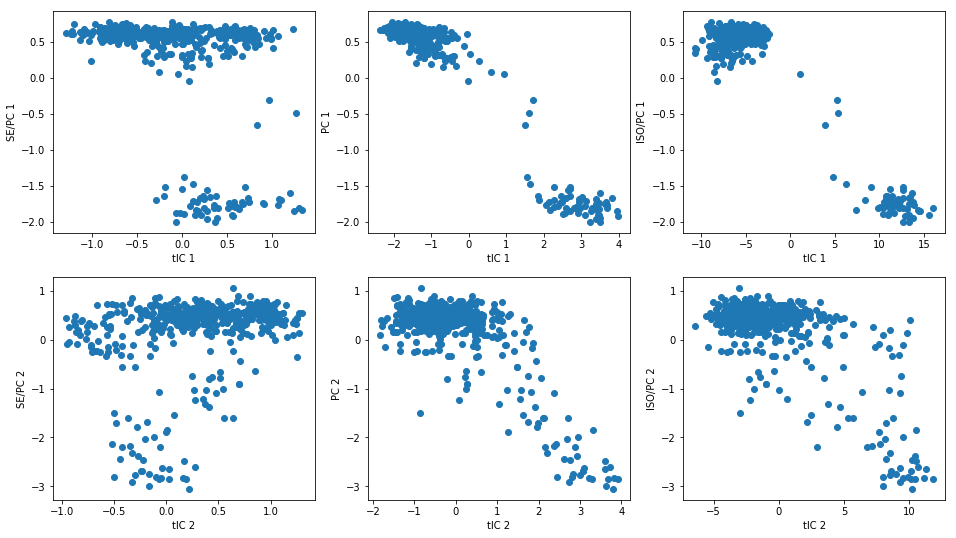

In [126]:
plt.figure(figsize=(4*4, 3*3))
num_points = 500
plt.subplot(2, 3, 1)
plot_against_tICA_comp(tICA_coordinates, X_se, 0, 0, indices, num_points); plt.ylabel('SE/PC 1'); plt.xlabel('tIC 1')
plt.subplot(2, 3, 2)
plot_against_tICA_comp(tICA_coordinates, X_pc, 0, 0, indices, num_points); plt.ylabel('PC 1'); plt.xlabel('tIC 1')
plt.subplot(2, 3, 4)
plot_against_tICA_comp(tICA_coordinates, X_se, 1, 1, indices, num_points); plt.ylabel('SE/PC 2'); plt.xlabel('tIC 2')
plt.subplot(2, 3, 5)
plot_against_tICA_comp(tICA_coordinates, X_pc, 1, 1, indices, num_points); plt.ylabel('PC 2'); plt.xlabel('tIC 2')
plt.subplot(2, 3, 3)
plot_against_tICA_comp(tICA_coordinates, X_iso, 0, 0, indices, num_points); plt.ylabel('ISO/PC 1'); plt.xlabel('tIC 1')
plt.subplot(2, 3, 6)
plot_against_tICA_comp(tICA_coordinates, X_iso, 1, 1, indices, num_points); plt.ylabel('ISO/PC 2'); plt.xlabel('tIC 2')

#### Energy landscapes

Dynamical directions found by tICA, Spectral Embedding and PCA

In [127]:
def plot_heatmap(X_se, label=False):
    x = X_se[:,0]
    y = X_se[:,1]
    xedges, yedges = np.linspace(min(x), max(x), 25), np.linspace(min(y), max(y), 25)
    hist, xedges, yedges = np.histogram2d(X_se[:,0],X_se[:,1],(xedges, yedges))
    #hist = np.log(hist)
    xidx = np.clip(np.digitize(X_se[:,0], xedges), 0, hist.shape[0]-1)
    yidx = np.clip(np.digitize(X_se[:,1], yedges), 0, hist.shape[1]-1)
    c = -np.log(hist[xidx, yidx])
    plt.scatter(X_se[:,0], X_se[:,1], c=c, edgecolor='none', cmap=plt.cm.Spectral)
    if label:
        cb = plt.colorbar()

C:\Users\minch_000\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: divide by zero encountered in log


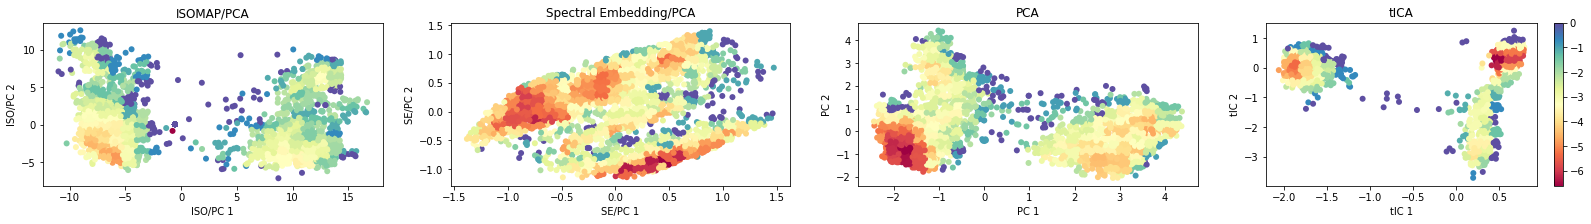

In [128]:
plt.figure(figsize=(4*7, 3))
plt.subplot(1, 4, 1)
plot_heatmap(X_iso); plt.xlabel('ISO/PC 1'); plt.ylabel('ISO/PC 2'); plt.title('ISOMAP/PCA')
plt.subplot(1, 4, 2)
plot_heatmap(X_se); plt.xlabel('SE/PC 1'); plt.ylabel('SE/PC 2'); plt.title('Spectral Embedding/PCA')
plt.subplot(1, 4, 3)
plot_heatmap(X_pc); plt.xlabel('PC 1'); plt.ylabel('PC 2'); plt.title('PCA')
plt.subplot(1, 4, 4)
plot_heatmap(tICA_coordinates[indices,:], label=True); plt.xlabel('tIC 1'); plt.ylabel('tIC 2'); plt.title('tICA')

#### Videos sampled along 1st tIC, PC, and Spectral Embedding dimension

These videos are sampled along the dominant dynamical modes found by tICA, PCA, and Spectral Embedding

In [129]:
X_XYZ = np.loadtxt(base + r'\apo_calmodulin\sim_datasets\raw_XYZ_' + str(num_frames) + '.csv', delimiter=',')

In [130]:
def save_traj(traj, filename):
    seq = np.reshape(traj, (traj.shape[0], int(traj.shape[1]/3), 3))
    md_traj = md.Trajectory(seq, md.load(base + r'\apo_calmodulin\1cfd_protein.pdb').topology)
    md_traj.save_xtc(base + r'\apo_calmodulin\videos\\' + filename)

In [131]:
# Sampled along first dimension
direction = tICA_coordinates[indices,0]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj, 'first_tICA_sample_' + str(num_frames) + '.xtc')

direction = X_se[:,0]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj, 'first_SE_dim_sample_' + str(num_frames) + '.xtc')

direction = X_pc[:,0]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj, 'first_PC_sample_' + str(num_frames) + '.xtc')

direction = X_iso[:,0]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj, 'first_ISO_sample_' + str(num_frames) + '.xtc')

In [132]:
# Sampled along second dimension
direction = tICA_coordinates[indices,1]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj, 'second_tICA_sample_' + str(num_frames) + '.xtc')

direction = X_se[:,1]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj, 'second_SE_dim_sample_' + str(num_frames) + '.xtc')

direction = X_pc[:,1]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj, 'second_PC_sample.xtc_' + str(num_frames) + '.xtc')

direction = X_iso[:,1]
idx_sort = direction.argsort()[-len(direction):][::-1]
traj = X_XYZ[idx_sort,:]
save_traj(traj, 'second_ISO_sample.xtc_' + str(num_frames) + '.xtc')

#### Calmodulin Specific Analysis - Apo/Holo Transition (Second dominant dynamic process)

The following analysis was inspired by Shukla et al's paper on calmodulin.
We measured the Phe92-Phe141 distance against the first dynamical mode found by PCA/SE/tICA.

In [133]:
phe92_atom = 178
phe141_atom = 912
phe92_idx = range(3*(phe92_atom-1), 3*(phe92_atom-1)+3)
phe141_idx = range(3*(phe141_atom-1), 3*(phe141_atom-1)+3)
phe92_coor = X_XYZ[:, phe92_idx]
phe141_coor = X_XYZ[:, phe141_idx]
dist_92_141 = np.sqrt(np.sum(((phe92_coor-phe141_coor)**2), axis=1))

In [134]:
def smooth(y, box_pts):
#     box = np.ones(box_pts)/box_pts
#     y_smooth = np.convolve(y, box, mode='valid')
    y_smooth = ndimage.filters.gaussian_filter1d(y, box_pts)
    return y_smooth

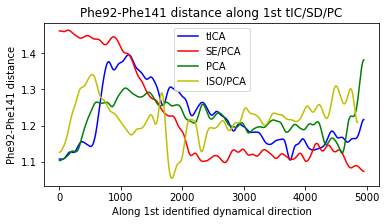

In [135]:
# When sorted by discovered dynamic directions
plt.figure(figsize=(3*2, 3))
idx_tica = tICA_coordinates[indices,1].argsort()[-len(tICA_coordinates[indices,1]):]
plt.plot(smooth(dist_92_141[idx_tica], 50), 'b', label='tICA'); 
plt.title('Phe92-Phe141 distance along 1st tIC/SD/PC')
plt.ylabel('Phe92-Phe141 distance'); plt.xlabel('Along 1st identified dynamical direction')
idx_se = X_se[:,1].argsort()[-len(X_se[:,1]):]#[::-1]
plt.plot(smooth(dist_92_141[idx_se], 50), 'r', label='SE/PCA'); 
idx_pc = X_pc[:,1].argsort()[-len(X_pc[:,1]):][::-1]
plt.plot(smooth(dist_92_141[idx_pc], 50), 'g', label='PCA');
idx_iso = X_iso[:,1].argsort()[-len(X_iso[:,1]):][::-1]
plt.plot(smooth(dist_92_141[idx_iso], 50), 'y', label='ISO/PCA');
plt.legend()

#### Calmodulin Specific Analysis - Partial Unfolding (Second dominant dynamic process)

The following analysis was inspired by Shukla et al's paper on calmodulin.
We measured the Met124-Ala128 distance against the second dynamical mode found by PCA/SE/tICA.

In [136]:
met124_atom = 660
ala128_atom = 735
met124_idx = range(3*(met124_atom-1), 3*(met124_atom-1)+3)
ala128_idx = range(3*(ala128_atom-1), 3*(ala128_atom-1)+3)
met124_coor = X_XYZ[:, met124_idx]
ala128_coor = X_XYZ[:, ala128_idx]
dist_124_128 = np.sqrt(np.sum(((met124_coor-ala128_coor)**2), axis=1))

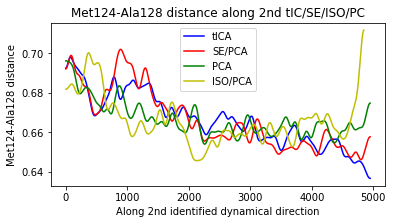

In [140]:
# When sorted by discovered dynamic directions
plt.figure(figsize=(3*2, 3))
idx_tica = tICA_coordinates[indices,1].argsort()[-len(tICA_coordinates[indices,1]):]
plt.plot(smooth(dist_124_128[idx_tica], 50), 'b', label='tICA'); 
plt.title('Met124-Ala128 distance along 2nd tIC/SE/ISO/PC')
plt.ylabel('Met124-Ala128 distance');  plt.xlabel('Along 2nd identified dynamical direction')
idx_se = X_se[:,1].argsort()[-len(X_se[:,1]):]#[::-1]
plt.plot(smooth(dist_124_128[idx_se], 50), 'r', label='SE/PCA'); 
idx_pc = X_pc[:,1].argsort()[-len(X_pc[:,1]):][::-1]
plt.plot(smooth(dist_124_128[idx_pc], 50), 'g', label='PCA');
idx_iso = X_iso[:,1].argsort()[-len(X_iso[:,1]):][::-1]
plt.plot(smooth(dist_124_128[idx_iso], 50), 'y', label='ISO/PCA');
plt.legend()

#### Excess code

In [138]:
# plt.figure(figsize=(3*4, 3))
# plt.subplot(1, 3, 1)
# plt.scatter(tICA_coordinates[indices, 0][::5], dist_92_141[::5]); plt.title('Phe92-Phe141 distance vs tIC 1')
# plt.ylabel('Phe92-Phe141 distance')
# plt.gca().invert_xaxis()
# plt.subplot(1, 3, 2)
# plt.scatter(X_se[:, 0][::5], dist_92_141[::5]); plt.title('Phe92-Phe141 distance vs SD 1')
# plt.subplot(1, 3, 3)
# plt.scatter(X_pc[:, 0][::5], dist_92_141[::5]); plt.title('Phe92-Phe141 distance vs PC 1')
# print('For tIC plt, x-axis is inverted for better viewing')

In [139]:
# plt.figure(figsize=(3*4, 3))
# plt.subplot(1, 3, 1)
# plt.scatter(tICA_coordinates[indices, 1][::5], dist_124_128[::5]); plt.title('Met124-Ala128 distance vs tIC 2')
# plt.ylabel('Met124-Ala128 distance')
# plt.gca().invert_xaxis()
# plt.subplot(1, 3, 2)
# plt.scatter(X_se[:, 1][::5], dist_124_128[::5]); plt.title('Met124-Ala128 distance vs SD 2')
# plt.subplot(1, 3, 3)
# plt.scatter(X_pc[:, 1][::5], dist_124_128[::5]); plt.title('Met124-Ala128 distance vs PC 2')
# print('For tIC plt, x-axis is inverted for better viewing')